In [1]:
import matplotlib.pyplot as mpl
import scipy.cluster.hierarchy as sch
import random
import numpy as np
import pandas as pd
%matplotlib inline

# 1) Generate correlated data

In [2]:
def generateData(nObs, size0, size1, sigma1):
    # Time series of correlated variables
    #1) generating some uncorrelated data
    np.random.seed(seed=12345)
    random.seed(12345)
    x = np.random.normal(0,1,size=(nObs,size0)) # each row is a variable
    #2) creating correlation between the variables
    cols = [random.randint(0, size0-1) for i in xrange(size1)]
    y = x[:, cols] + np.random.normal(0, sigma1, size=(nObs, len(cols)))
    x = np.append(x, y, axis=1)
    x = pd.DataFrame(x, columns=range(1, x.shape[1] + 1))
    return x, cols

In [3]:
nObs,size0,size1,sigma1 = 10000,5,5,.25
x, cols = generateData(nObs, size0, size1, sigma1)

In [4]:
print [(j+1,size0+i) for i,j in enumerate(cols,1)]

[(3, 6), (1, 7), (5, 8), (2, 9), (2, 10)]


In [5]:
x.tail()

,1,2,3,4,5,6,7,8,9,10
9995,3.024868,1.608706,0.222607,-1.002391,-1.052142,0.145550,2.856461,-0.898981,1.416062,1.754102
9996,0.009564,1.134083,-0.333766,-1.091950,-0.915227,-0.587262,0.366653,-1.495926,0.875206,0.887250
9997,-1.270282,0.809146,-0.450842,0.471795,1.894011,0.001885,-1.309590,1.788093,0.932708,0.924528
9998,-0.688909,0.088575,-0.563593,-0.411351,0.651575,-0.668777,-0.961016,0.494739,-0.016414,-0.162293
9999,0.512041,0.653848,-1.988493,-2.144291,-0.341869,-1.873981,1.212201,-0.376840,0.473976,0.713480


# 2) compute and plot correl matrix

In [17]:
def plotCorrMatrix(path, corr, labels=None):
    # Heatmap of the correlation matrix
    if labels is None:
        labels = []
    mpl.pcolor(corr)
    mpl.colorbar()
    mpl.yticks(np.arange(.5,corr.shape[0] + .5),labels)
    mpl.xticks(np.arange(.5,corr.shape[0] + .5),labels)
    mpl.savefig(path)
#     mpl.clf();
    mpl.show()
#     mpl.close() # reset pylab
    return

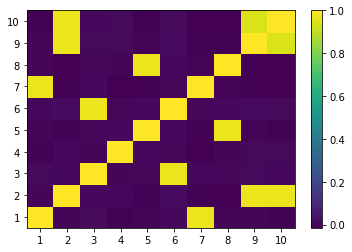

In [7]:
cov, corr = x.cov(), x.corr()
plotCorrMatrix('HRP3_corr0.png', corr, labels=corr.columns)

# 3) cluster

In [8]:
def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist=((1 - corr) / 2.) ** .5 # distance matrix
    return dist

In [9]:
def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1,0],link[-1,1]])
    numItems = link[-1,3] # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0]*2, 2) # make space
        df0 = sortIx[sortIx >= numItems] # find clusters
        i = df0.index;
        j = df0.values - numItems
        sortIx[i] = link[j,0] # item 1
        df0 = pd.Series(link[j,1], index=i+1)
        sortIx = sortIx.append(df0) # item 2
        sortIx = sortIx.sort_index() # re-sort
        sortIx.index = range(sortIx.shape[0]) # re-index
    return sortIx.tolist()

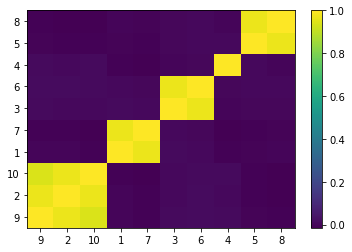

In [10]:
dist = correlDist(corr)
link = sch.linkage(dist,'single')
sortIx = getQuasiDiag(link)
sortIx = corr.index[sortIx].tolist() # recover labels
df0 = corr.loc[sortIx,sortIx] # reorder
plotCorrMatrix('HRP3_corr1.png', df0, labels=df0.columns)

# 4) Capital allocation

In [12]:
def getIVP(cov, **kargs):
    # Compute the inverse-variance portfolio
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

In [13]:
def getClusterVar(cov, cItems):
    # Compute variance per cluster
    cov_ = cov.loc[cItems, cItems] # matrix slice
    w_ = getIVP(cov_).reshape(-1,1)
    cVar = np.dot(np.dot(w_.T, cov_), w_)[0,0]
    return cVar

In [14]:
def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx] # initialize all items in one cluster
    while len(cItems)>0:
        cItems=[i[j:k] for i in cItems for j, k in ((0,len(i)/2), \
            (len(i) / 2, len(i))) if len(i) > 1] # bi-section
        for i in xrange(0, len(cItems), 2): # parse in pairs
            cItems0 = cItems[i] # cluster 1
            cItems1 = cItems[i + 1] # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha # weight 1
            w[cItems1] *= 1-alpha # weight 2
    return w

In [15]:
hrp = getRecBipart(cov,sortIx)

In [16]:
hrp

9     0.071239
2     0.075922
10    0.127903
1     0.069994
7     0.066189
3     0.108389
6     0.101915
4     0.190291
5     0.097199
8     0.090959
dtype: float64